# MUSIC Super-resolution Microscopy

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Program Parameters

In [2]:
class params:
    k     = 2     # Source number
    M     = 8     # Sensor number
    T     = 200   # Snapshot number
    noise = 0.001 # Noise power
    sep   = 3     # Source inter-separation distance
    sig   = 2     # Gaussian kernel variance
    Q     = 5000  # MUSIC 'Resolution'
p = params()

## Model

$$ f = Us$$ where $[U]_{m,k} = u(r_m - r_k) = \exp(-\frac{1}{2\sigma^2} (r_m - r_k)^2)$

## Generation of U Matrix

In [3]:
# Evenly spaced sources
w = np.linspace(-p.sep/2,p.sep/2,p.k)

# Uniform Linear Array (ULA)
v1 = np.arange(0,p.M).reshape(-1,1) - p.M/2

# Build the Gaussian (U matrix)
X = np.zeros((p.M,p.k));
X = X[...,:] + v1;
X = X[:,...] - w;
U = np.exp(-0.5*np.square(X/p.sig))

## Measurement Data Generation

In [4]:
# Random Data
x = np.random.randn(p.k,p.T)
# Additive Gaussian Noise
n = p.noise * np.random.randn(p.M,p.T)

# Measurements
f = U @ x + n

## Autocorrelation Estimates

In [5]:
R_ff = 1/p.T * f @ f.T

## Perform MUSIC

In [6]:
def MUSIC(R_ff, v1, L, sig, Q):
    # Perform Eigenvalue Decomposition on autocorrelation matrix
    U,_,_ = np.linalg.svd(R_ff)
    
    # Segment 
    V1 = U[:,:L]
    V2 = U[:,L:]
    print(V2.shape)
    
    # Build MUSIC high-resolution 'grid'
    v2 = np.linspace(-3,3,Q)
    
    # Build new matrix
    X = np.zeros((len(v1),len(v2)))
    X = X[...,:] + v1;
    X = X[:,...] - v2;
    
    A = np.exp(-0.5*np.square(X/sig))
    
    img = np.zeros((Q,1))
    
    for k in range(Q):
        NOISE = A[:,k].conj().T @ ( V2 @ V2.conj().T ) @ A[:,k]
        img[k] = 1/NOISE
    
    return img

In [7]:
img = MUSIC(R_ff,v1,p.k,p.sig,p.Q)

(8, 6)


## Results

<IPython.core.display.Javascript object>


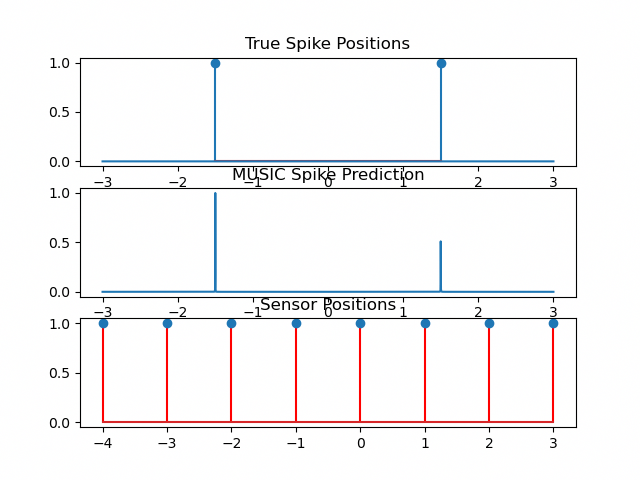

In [29]:
axiss = np.linspace(-3,3,p.Q)

plt.figure()
plt1 = plt.subplot(3,1,1)
plt.stem(w,np.ones(w.shape))
plt.plot(axiss,np.zeros((p.Q,1)))
plt.title('True Spike Positions')

plt2 = plt.subplot(3,1,2,sharex=plt1)
plt.plot(axiss,img/np.max(img))
plt.title('MUSIC Spike Prediction')

plt3 = plt.subplot(3,1,3)
plt.stem(v1,np.ones(v1.shape),'r')
plt.title('Sensor Positions')

plt.show()